In [3]:
import pandas as pd
import arff

# Load the .arff file
file_path = './data/EEG_Eye_State.arff'  # Update the path if necessary
with open(file_path, 'r') as f:
    arff_data = arff.load(f)

# Convert to pandas DataFrame
data = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("First 5 Rows:")
print(data.head())

Dataset Shape: (14980, 15)
First 5 Rows:
       AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   

        P8       T8      FC6       F4       F8      AF4 eyeDetection  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85            0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10            0  
2  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23            0  
3  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41            0  
4  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46            0  


In [5]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Display basic statistics
print("\nBasic Statistics:\n", data.describe())

# Check the distribution of the target variable (Eye_State)
print("\nTarget Variable Distribution:")


Missing Values:
 AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

Basic Statistics:
                  AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.6200

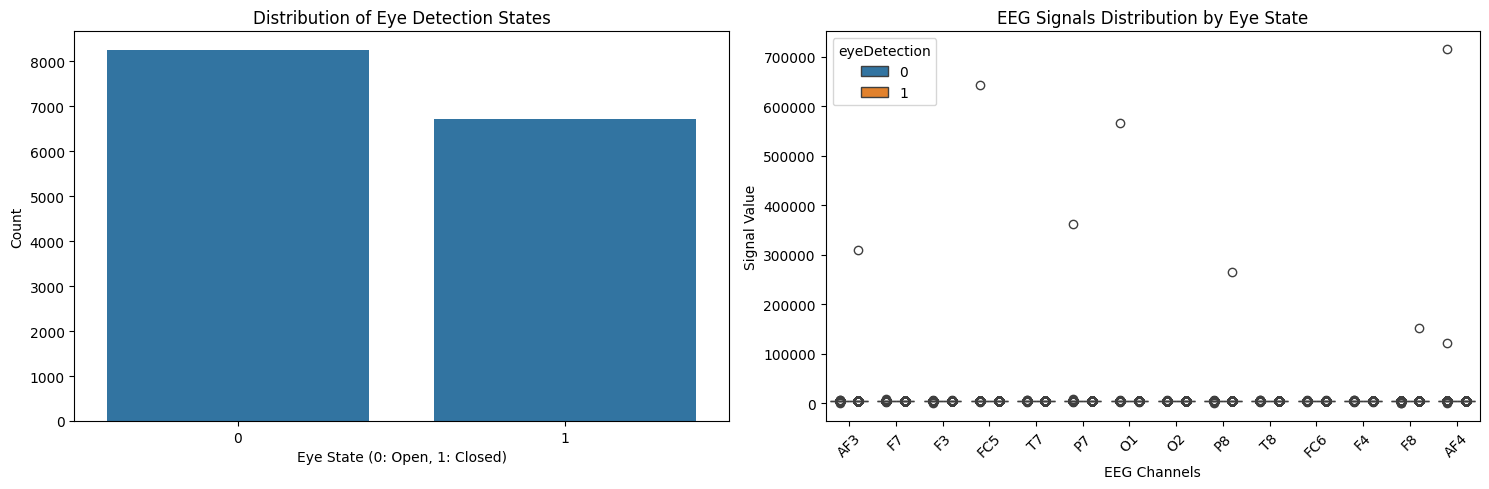

In [6]:
import seaborn as sns

# Import visualization libraries
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of eyeDetection
sns.countplot(data=data, x='eyeDetection', ax=ax1)
ax1.set_title('Distribution of Eye Detection States')
ax1.set_xlabel('Eye State (0: Open, 1: Closed)')
ax1.set_ylabel('Count')

# Plot 2: Box plot of EEG signals by eye state
data_melted = data.melt(id_vars=['eyeDetection'], 
                        value_vars=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 
                                  'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
sns.boxplot(data=data_melted, x='variable', y='value', hue='eyeDetection', ax=ax2)
ax2.set_title('EEG Signals Distribution by Eye State')
ax2.set_xlabel('EEG Channels')
ax2.set_ylabel('Signal Value')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [8]:
print(data.columns)

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = data.drop(columns=['eyeDetection'])  # Features
y = data['eyeDetection']  # Target

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (11984, 14)
Testing Set Shape: (2996, 14)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the autoencoder
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

# Denoise the data
X_train_denoised = autoencoder.predict(X_train)
X_test_denoised = autoencoder.predict(X_test)

print("Denoised Data Shape:", X_train_denoised.shape)

2025-04-19 17:01:58.173927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 17:01:58.450590: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 17:01:58.563994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745082118.843639    7847 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745082118.938197    7847 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745082119.594931    7847 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/50


2025-04-19 17:02:03.084859: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2635 - val_loss: 0.0317
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9001 - val_loss: 0.0091
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3029 - val_loss: 0.0249
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9252 - val_loss: 0.0044
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7483 - val_loss: 0.0052
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0614 - val_loss: 0.0108
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7643 - val_loss: 0.0143
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1198 - val_loss: 0.0077
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1328 - val_loss: 0.0079
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0793 - val_loss: 0.0045
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0714 - val_loss: 0.0057
Epoch 12/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

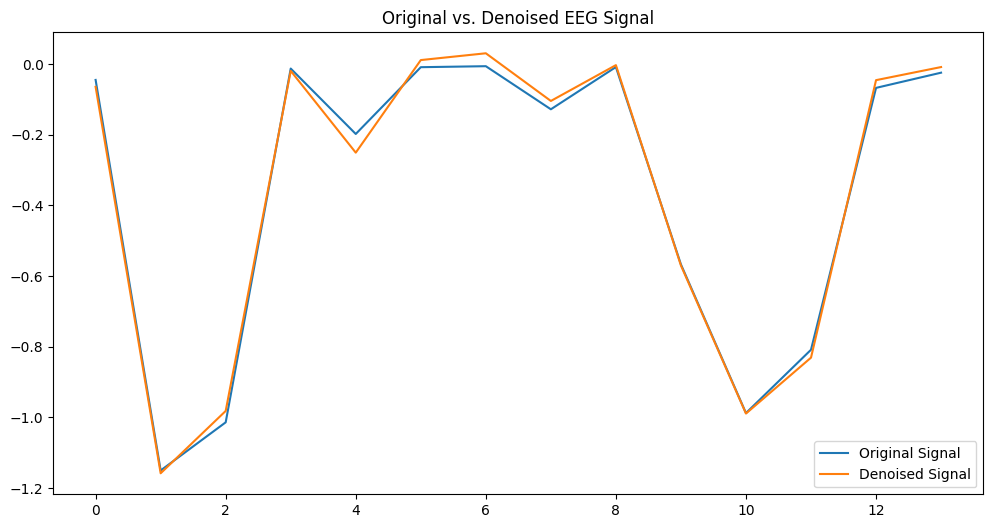

In [11]:
import matplotlib.pyplot as plt

# Plot original vs. denoised signals
plt.figure(figsize=(12, 6))
plt.plot(X_train[0], label='Original Signal')
plt.plot(X_train_denoised[0], label='Denoised Signal')
plt.legend()
plt.title('Original vs. Denoised EEG Signal')
plt.show()

In [14]:
import numpy as np

# Reshape the data for CNN (add a channel dimension)
X_train_cnn = X_train_denoised.reshape(X_train_denoised.shape[0], X_train_denoised.shape[1], 1)
X_test_cnn = X_test_denoised.reshape(X_test_denoised.shape[0], X_test_denoised.shape[1], 1)

print("CNN Input Shape (Training):", X_train_cnn.shape)
print("CNN Input Shape (Testing):", X_test_cnn.shape)

CNN Input Shape (Training): (11984, 14, 1)
CNN Input Shape (Testing): (2996, 14, 1)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

# Define the CNN model
cnn = Sequential([
    Input(shape=(X_train_cnn.shape[1], 1)),  # Input shape: (timesteps, features)
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 14, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,977 (74.13 KB)

 Trainable params: 18,977 (74.13 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Ensure X_train_cnn is numeric
X_train_cnn = X_train_cnn.astype('float32')
X_test_cnn = X_test_cnn.astype('float32')

# Ensure y_train and y_test are numeric
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [20]:
# Train the CNN
history = cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5656 - loss: 0.6727 - val_accuracy: 0.6233 - val_loss: 0.6397
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6060 - loss: 0.6469 - val_accuracy: 0.6604 - val_loss: 0.6122
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6610 - loss: 0.6100 - val_accuracy: 0.6667 - val_loss: 0.6054
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6656 - loss: 0.6332 - val_accuracy: 0.6850 - val_loss: 0.5784
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6865 - loss: 0.5769 - val_accuracy: 0.6838 - val_loss: 0.5692
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6968 - loss: 0.5592 - val_accuracy: 0.6988 - val_loss: 0.5575
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7125 - loss: 0.5505 - val_accuracy: 0.7088 - val_loss: 0.5511
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7292 - loss: 0.5341 - val_accuracy: 0.7309 - val_

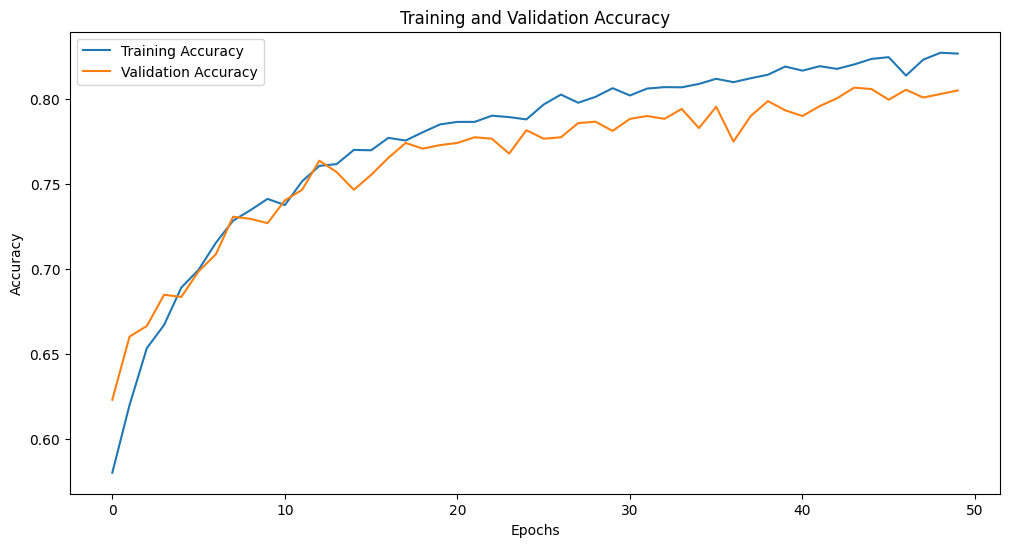

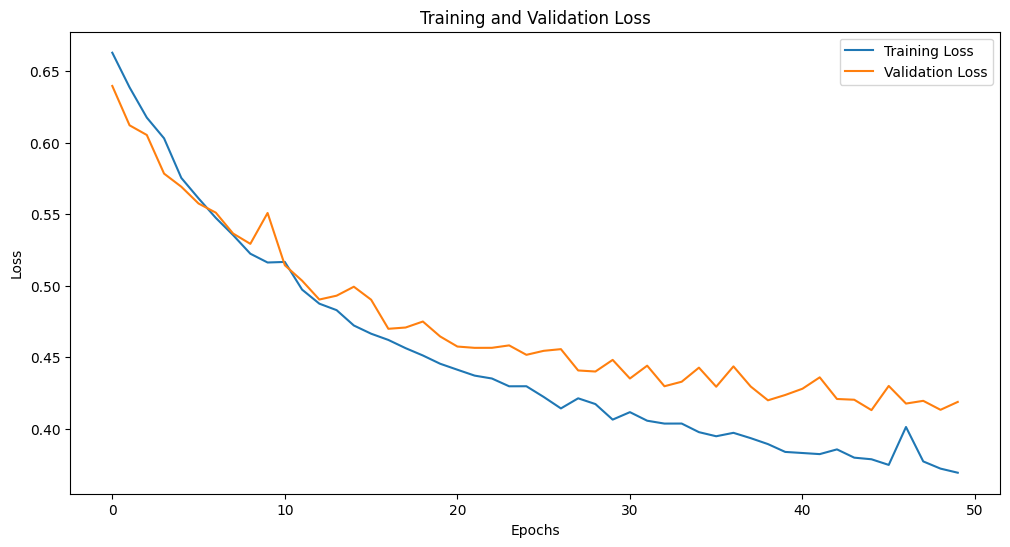

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Predict on the test set
y_pred = (cnn.predict(X_test_cnn) > 0.5).astype(int)

# Evaluate predictions
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1316  270]
 [ 357 1053]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      1586
         1.0       0.80      0.75      0.77      1410

    accuracy                           0.79      2996
   macro avg       0.79      0.79      0.79      2996
weighted avg       0.79      0.79      0.79      2996

